In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import pickle


mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = True 

TensorFlow 2.x selected.


In [0]:
# load data located ashrae_data into dataframes 
train_csv_path = '/content/drive/My Drive/ashrae_data/train.csv'
weather_train_csv_path = '/content/drive/My Drive/ashrae_data/weather_train.csv'
test_csv_path = '/content/drive/My Drive/ashrae_data/test.csv'
building_metadata_csv_path = '/content/drive/My Drive/ashrae_data/building_metadata.csv' 
primary_usage_translations_csv_path = '/content/drive/My Drive/ashrae_data/primary_usage_translations.csv' 

train_df = pd.read_csv(train_csv_path) #, nrows = 1000000)
weather_train_df = pd.read_csv(weather_train_csv_path) #, nrows = 1000000)
# test_df = pd.read_csv(test_csv_path) #, nrows = 1000000)
building_metadata_df = pd.read_csv(building_metadata_csv_path) #, nrows = 1000000)
primary_usage_translations_df = pd.read_csv(primary_usage_translations_csv_path)

## Visualizing a sample
To get a feel for the data, let's have a look at a few example meter readings from a random building.
We pick a sample of size 120 to get energy consumptions for a five day timeframe.

,building_id,meter,timestamp,meter_reading
200,173,1,2016-01-01 00:00:00,19.3427
201,174,0,2016-01-01 00:00:00,179.9000
202,174,1,2016-01-01 00:00:00,52.8583
203,175,0,2016-01-01 00:00:00,86.5900
204,175,1,2016-01-01 00:00:00,116.3370
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.7500
20216096,1445,0,2016-12-31 23:00:00,4.8250
20216097,1446,0,2016-12-31 23:00:00,0.0000
20216098,1447,0,2016-12-31 23:00:00,159.5750


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfc0038e48>],
      dtype=object)

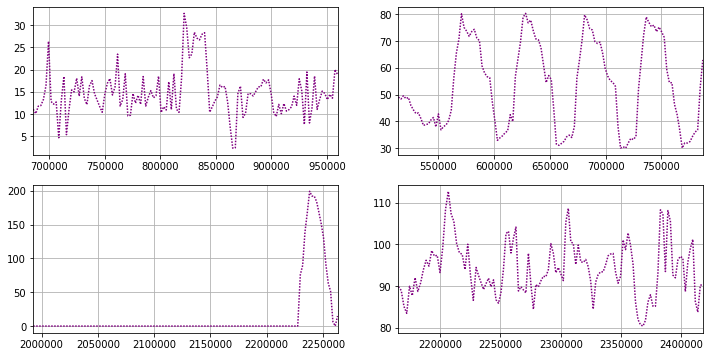

In [20]:
# get random variables that will be used to collect the data...
sample_building_ids = [np.random.randint(200,300) for i in range(4)]
sample_starts = [np.random.randint(0,1000) for i in range(4)]
# train_df = train_df.fillna(0)


# collect samples
sample1 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[0]].loc[train_df.meter == 0][sample_starts[0]:sample_starts[0] + 120]
sample2 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[1]].loc[train_df.meter == 0][sample_starts[1]:sample_starts[1] + 120]
sample3 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[2]].loc[train_df.meter == 1][sample_starts[2]:sample_starts[2] + 120]
sample4 = train_df.meter_reading.loc[train_df.building_id == sample_building_ids[3]].loc[train_df.meter == 1][sample_starts[3]:sample_starts[3] + 120]

# sample1 = sample1.fillna(0)
# sample2 = sample2.fillna(0)
# sample3 = sample3.fillna(0)
# sample4 = sample4.fillna(0)
# init figure
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,6))
# plot the samples
sample1.plot(ax = axes[0][0],subplots=True, linestyle = (0, (1,1)), color = 'purple')
sample2.plot(ax = axes[0][1],subplots=True, linestyle = (0, (1,1)), color = 'purple')
sample3.plot(ax = axes[1][0],subplots=True, linestyle = (0, (1,1)), color = 'purple')
sample4.plot(ax = axes[1][1],subplots=True, linestyle = (0, (1,1)), color = 'purple')

In [0]:
def convert_timestamp(timestamp):
    return int(timestamp[5:14].replace(' ','').replace('-','').replace(':',''))


def get_sample(building_id, meter, start, size, split):
    """
    data:
                    site    building_id     meter   meter_reading   air_temp    cloud_coverage  wind_speed  wind_direction  ...
    time start
    time start+1
    ...
    time split

    labels:
                    meter_reading
    time split+1
    time split+2
    ....
    time start+size
    """
    site_id = building_metadata_df['site_id'].loc[building_metadata_df['building_id']==building_id].values[0] # get site_id of building

    # get train and weather data in relevant time window
    t = train_df[['timestamp', 'meter_reading']].loc[train_df['building_id']==building_id].loc[train_df['meter'] == meter][start:start+size] #?
    w = weather_train_df[['timestamp','air_temperature','cloud_coverage','precip_depth_1_hr','wind_speed']].loc[weather_train_df['site_id']==site_id][start:start+size] # TRY maybe remove timestamp to avoid merge problems
    t.set_index('timestamp')
    w.set_index('timestamp')
    # t.fillna(0)
    # w.fillna(0)
    # print(t.shape)

    # if t.shape[0] == size:

    # merge if t.shape[0] == size
    # else disguise
    # print(w.shape)
    # print(meter) # meter 2 is not stable
    # print()
    # i thiiiiiiiiiink something goes wrong on merging...
    sample_merged = pd.merge(t, w, on=['timestamp']) # merge the two
    sample_merged.timestamp = sample_merged.timestamp.apply(convert_timestamp) # make timestamp numeric
    sample_merged = (sample_merged - sample_merged.mean()) / sample_merged.std() # standardize the data
    sample_merged = sample_merged.fillna(0) # replace nan values with zeros
    sample_merged['site_id'] = [site_id for x in range(sample_merged.shape[0])] # add site_id as column
    sample_merged['building_id'] = [building_id for x in range(sample_merged.shape[0])]
    sample_merged['meter'] = [meter for x in range(sample_merged.shape[0])]

# todo add building_id

    data = sample_merged[:split] # split into data...
    labels = sample_merged['meter_reading'][split:] # ...aaand labels

    # print(data.shape)
    # print(labels.shape)
    return data.to_numpy(), labels.to_numpy()#, sample_merged # return as numpy array


def pick_samples(num_buildings = 1, start_range = (0,10), offset = 0):
    """ Use get_sample to build a training data set. """
    all_data, all_labels = [],[]
    building_ids = train_df.building_id.unique()
    # print(building_ids)
    c = 0
    for id in building_ids[offset:offset+num_buildings]:
        for start in range(start_range[0], start_range[1], 10):
            # print(start) 
            # for meter in train_df.meter.unique(): #TODOOOOOOOOOOOOOOOOOOOOOOOOOO some meters cause trouble
            # for meter in [0,1,3]: #just try 1
            for meter in [0,1]: #just try 1
                c += 1
                # print(meter)
                data, labels = get_sample(id, meter, start, 5*24,4*24) # TODO pass this as parameter
                all_data.append(data)
                all_labels.append(labels)
                if c%500 == 0:
                    print("sample {} of {}...".format(c, num_buildings * 2 * ((start_range[1]-start_range[0]) / 10)))

    return all_data, all_labels




# dfs = []
# for i in range(50):
#     id = np.random.randint(200,240)
#     meter = np.random.randint(0,1)
#     start = np.random.randint(0,300)
#     # print(meter)
#     x, y = get_sample(id, meter, start, 5*24, 4*24)
#     # dfs.append(df)
#     # print(y.shape)
#     # print("building: {}\nmeter: {}\n start: {}\nx_shape: {}\n y_shape: {}\n\n".format(id, meter, start, x.shape, y.shape))



# # x_train,y_train = pick_samples(10, start_range = (0,100), offset=200)
# # x_val,y_val = pick_samples(2, start_range= (0,100), offset = 210)

# # test_x, test_y = pick_samples(10, start_range = (0,100), offset=100)


In [86]:
# display(df[:96], 20)
# print(y.shape)
display(dfs[np.random.randint(0,49)])

# x, y, df = get_sample(200, 1, 249, 5*24, 4*24)

,timestamp,meter_reading,air_temperature,cloud_coverage,precip_depth_1_hr,wind_speed,site_id,building_id,meter
0,-0.726447,-0.635721,-0.370081,0.284122,0.0,-0.902608,2,216,216
1,-0.726447,-1.404485,-0.370081,0.284122,0.0,-0.902608,2,216,216
2,-0.726447,-1.462126,-0.370081,0.284122,0.0,-0.902608,2,216,216
3,-0.674389,-0.638475,-0.493816,-0.966015,0.0,-1.608440,2,216,216
4,-0.674389,-1.380045,-0.493816,-0.966015,0.0,-1.608440,2,216,216
...,...,...,...,...,...,...,...,...,...
61,0.314715,-0.817920,1.708672,0.284122,0.0,-0.620276,2,216,216
62,0.314715,-1.269987,1.708672,0.284122,0.0,-0.620276,2,216,216
63,4.323186,-0.484013,1.560189,0.284122,0.0,-0.384999,2,216,216
64,4.323186,-0.763045,1.560189,0.284122,0.0,-0.384999,2,216,216


In [23]:
x_train, y_train = pick_samples(50, start_range = (0,1000), offset=200)
x_val, y_val = pick_samples(10, start_range= (0,1000), offset = 250)

sample 500 of 10000.0...
sample 1000 of 10000.0...
sample 1500 of 10000.0...
sample 2000 of 10000.0...
sample 2500 of 10000.0...
sample 3000 of 10000.0...
sample 3500 of 10000.0...
sample 4000 of 10000.0...
sample 4500 of 10000.0...
sample 5000 of 10000.0...
sample 5500 of 10000.0...
sample 6000 of 10000.0...
sample 6500 of 10000.0...
sample 7000 of 10000.0...
sample 7500 of 10000.0...
sample 8000 of 10000.0...
sample 8500 of 10000.0...
sample 9000 of 10000.0...
sample 9500 of 10000.0...
sample 10000 of 10000.0...
sample 500 of 2000.0...
sample 1000 of 2000.0...
sample 1500 of 2000.0...
sample 2000 of 2000.0...


## Cleaning the Data
Sometimes there aren't 24 values for a label, so we need to remove those rows. This way we will avoid problems down below.


In [24]:
def remove_broken_samples(data, labels, output_shape = 24):
    """ Removes samples where output dimension doesn't match the required size. """
    clean_data, clean_labels = [], []
    broken_sample_count = 0
    working_sample_count = 0
    for i, label in enumerate(labels):
        if label.shape[0] == output_shape:
            clean_data.append(data[i])
            clean_labels.append(labels[i])
            working_sample_count += 1
        else:
            broken_sample_count += 1
    
    print("Removed {} samples... {} remaining.".format(broken_sample_count, working_sample_count))
    
    return clean_data, clean_labels



x_train,y_train = remove_broken_samples(x_train, y_train)
x_val,y_val = remove_broken_samples(x_val, y_val)

Removed 1328 samples... 8672 remaining.
Removed 376 samples... 1624 remaining.


## Store the training data
To avoid sampling the data all over again each time we store it in a pickle file. This will allow us to load it much faster the next time.

In [0]:
# !ls drive/My\ Drive/ashrae_data

def pickle_data(filename, data):
    with open('/content/drive/My Drive/ashrae_data/' + filename, 'wb') as f:
        pickle.dump(data,f)


pickle_data('train_samples_x.pkl', x_train)
pickle_data('train_samples_y.pkl', y_train)
pickle_data('val_samples_x.pkl', x_val)
pickle_data('val_samples_y.pkl', y_val)

## Load the pickled data
Let's load the data from the pickle files!

In [0]:
with open('/content/drive/My Drive/ashrae_data/' + 'train_samples_x.pkl', 'rb') as f:
    x_train = pickle.load(f)

with open('/content/drive/My Drive/ashrae_data/' + 'train_samples_y.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('/content/drive/My Drive/ashrae_data/' + 'val_samples_x.pkl', 'rb') as f:
    x_val = pickle.load(f)

with open('/content/drive/My Drive/ashrae_data/' + 'val_samples_y.pkl', 'rb') as f:
    y_val = pickle.load(f)

In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)



(24,)


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data = val_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()



## Defining the Model
After collecting and preparing all the data we create a model...

In [82]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    32,
    return_sequences = True,
    input_shape=(x_train[0].shape)
))
# model.add(tf.keras.layers.Attention())
# model.add(tf.keras.layers.LSTM(16,activation='tanh')) # was relu
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))

model.add(tf.keras.layers.Dense(24))

model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),loss='mae')


(96, 9)


In [63]:
class AshraeModel(tf.keras.Model):
    def __init__(self):
        super(AshraeModel, self).__init__()


        # self.lstm1 = tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(96,9)) # was 32
        self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(96,9))) # was 32

        self.lstm2 = tf.keras.layers.LSTM(128,return_sequences=True)

        self.bi_lsmt = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation = 'tanh')) # is much faster than relu and performs similarly
        self.out = tf.keras.layers.Dense(24)


    def call(self,inputs):
        # context_vector, attention_weights = self.attention(hidden, enc_output)

        query_value_attention_seq = tf.keras.layers.Attention()([inputs, inputs])
        query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(query_value_attention_seq)
        query_encoding = tf.keras.layers.GlobalAveragePooling1D()(inputs)

        # input_layer = tf.keras.layers.Concatenate()([query_encoding, query_value_attention])
        input_layer = tf.keras.layers.Concatenate()([inputs, query_value_attention_seq])

        x = self.lstm1(input_layer)
        x = tf.nn.dropout(x, 0.2)
        x = self.lstm2(x)
        x = tf.nn.dropout(x, 0.2)
        x = self.bi_lsmt(x)
        x = self.out(x)
        
        return x


model2 = AshraeModel()
model2.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),loss='mae')
model2.build((8,96,9))
model2.summary()

Model: "ashrae_model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio multiple                  150528    
_________________________________________________________________
lstm_33 (LSTM)               multiple                  197120    
_________________________________________________________________
bidirectional_24 (Bidirectio multiple                  98816     
_________________________________________________________________
dense_11 (Dense)             multiple                  3096      
Total params: 449,560
Trainable params: 449,560
Non-trainable params: 0
_________________________________________________________________


In [64]:
EVALUATION_INTERVAL = 100
EPOCHS = 500


history = model2.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50
                    )



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 100 steps, validate for 50 steps
Epoch 1/500
100/100 [==============================] - 12s 123ms/step - loss: 0.8625 - val_loss: 0.7341
Epoch 2/500
100/100 [==============================] - 3s 31ms/step - loss: 0.7534 - val_loss: 0.6107
Epoch 3/500
100/100 [==============================] - 3s 30ms/step - loss: 0.6393 - val_loss: 0.5549
Epoch 4/500
100/100 [==============================] - 3s 31ms/step - loss: 0.5731 - val_loss: 0.5484
Epoch 5/500
100/100 [==============================] - 

0


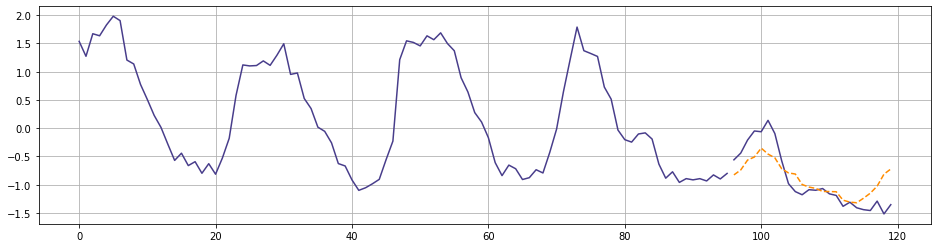

0


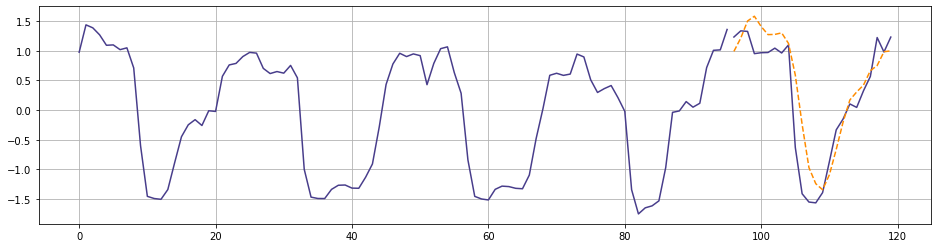

0


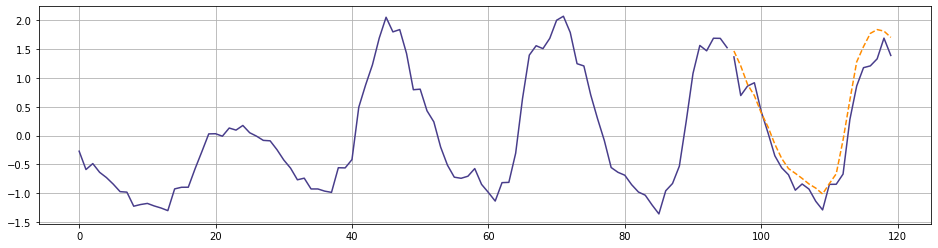

0


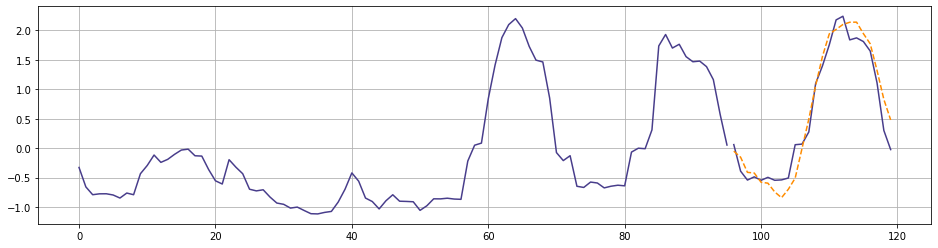

In [66]:
mpl.rcParams['figure.figsize'] = (16, 4)


# make prediction after training
for x, y in val_data.take(4):
    # each is mini batch of size 8
    r = np.random.randint(0, BATCH_SIZE-1)
    # print(r)
    meter = int(x[r][2][8])
    print(meter)
    meter_readings_x = [i[1] for i in x[r]] # pick random sample from mini batch
    prediction = model2.predict(x)[r]
    # print(len(meter_readings))
    # print(prediction.shape)



    plt.plot([x for x in range(96)], meter_readings_x, color = 'darkslateblue')
    plt.plot([x for x in range(96, 120)],y[r], color = 'darkslateblue')#, linestyle = 'dashed')
    plt.plot([x for x in range(96, 120)], prediction, linestyle = 'dashed', color = 'darkorange')
    plt.show()


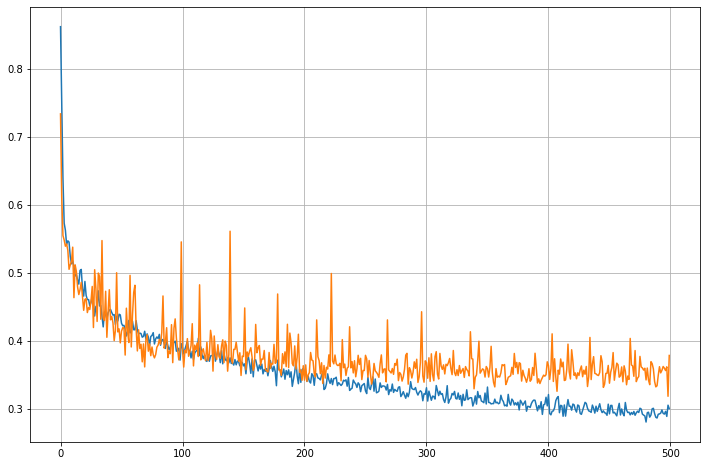

In [67]:
# print(history.history['val_loss'])
mpl.rcParams['figure.figsize'] = (12, 8)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
